In [101]:
# Import necessary libraries
from pykalman import KalmanFilter
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

(2031, 6)
(2031, 6)


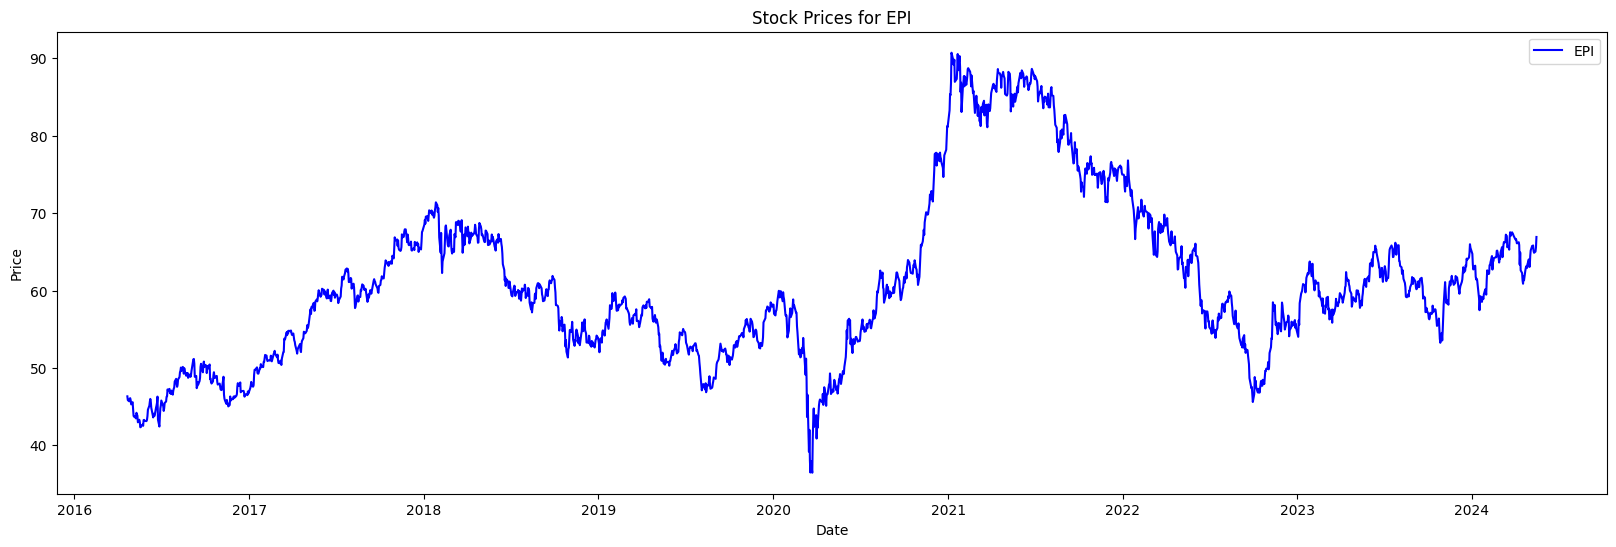

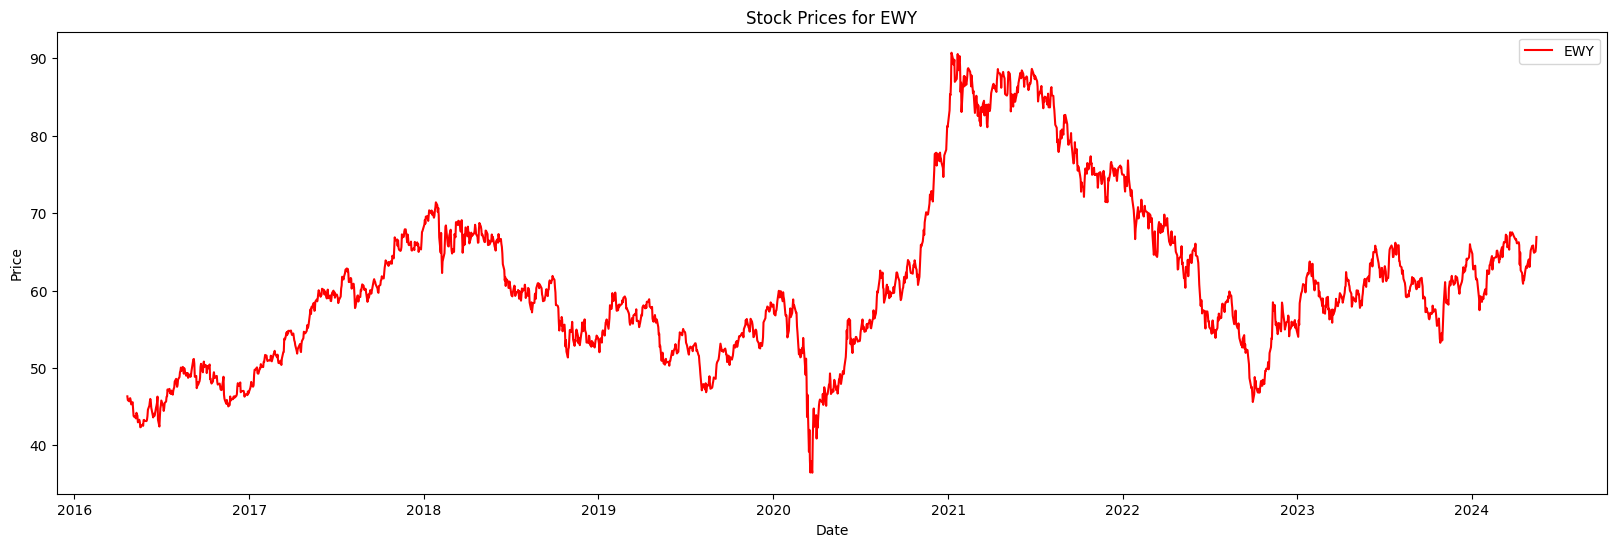

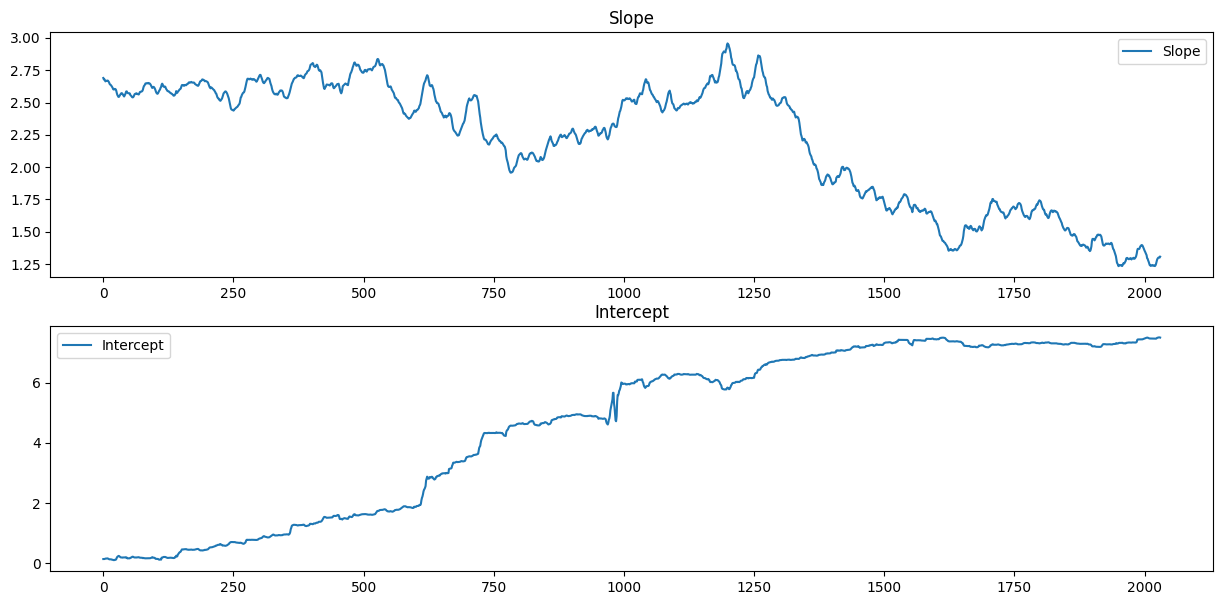

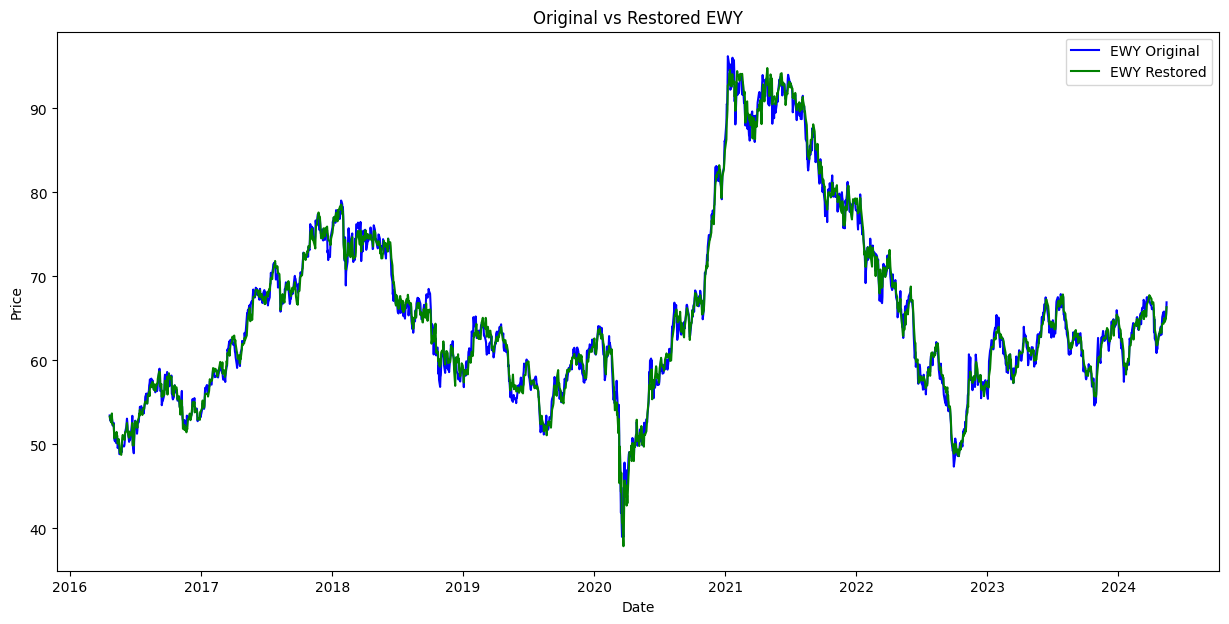

Mean Slope: 2.2086397912265934
Mean Intercept: 4.615293898730203
[[ 0.13605601]
 [-0.21306845]
 [ 0.08185708]
 ...
 [ 0.05520188]
 [-0.12663629]
 [ 0.58123741]]
(2031, 1)
(2031,)
(2031, 1)
ADF Statistic: -17.07537730473998
p-value: 7.77337032720145e-30
Critical Values: {'1%': -3.4335754129266802, '5%': -2.862964825335276, '10%': -2.567528514159528}


In [102]:
# Set up date range
startDate = datetime(2016, 4, 21)
endDate = datetime.today()

ticker1 = 'EPI'
ticker2 = 'EWY'
# Fetch data for ticker1
Stock1= yf.download(ticker1, start=startDate, end=endDate, progress=False)

# Fetch data for ticker2
Stock2 = yf.download(ticker2, start=startDate, end=endDate, progress=False)

# Display shapes of fetched dataframes
print(Stock1.shape)
print(Stock2.shape)

# Plot stock prices
plt.figure(figsize=(20, 6))
plt.plot(Stock1.index, Stock2['Adj Close'], label=ticker1, color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices for '+ticker1)
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(Stock1.index, Stock2['Adj Close'], label=ticker2, color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices for '+ticker2)
plt.legend()
plt.show()

# Extract closing prices
s1 = Stock1[['Close']].values
s2 = Stock2[['Close']].values

# Prepare data for Kalman Filter
H = np.insert(s1, s1.shape[1], 1, axis=1)
H = H.reshape(len(s1), 1, 2)
F = np.eye(2)
Q = [[1e-4, 0], [0, 1e-4]]
R = 1
X0 = [0, 0]
P0 = [[1, 0], [0, 1]]

# Initialize Kalman Filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  transition_matrices=F,
                  observation_matrices=H,
                  transition_covariance=Q,
                  observation_covariance=R,
                  initial_state_mean=X0,
                  initial_state_covariance=P0)

# Filtering
state_means, state_covs = kf.filter(s2)

# Extract beta (slope) and intercept from state_means
beta = state_means[:, 0]
intc = state_means[:, 1]

# Reshape beta and intercept arrays
beta = beta.reshape(len(beta), 1)
intc = intc.reshape(len(intc), 1)

# Restore EWC based on EWA and estimated parameters
s2_restored = (s1 * beta + intc)

# Plot slope and intercept
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(beta, label="Slope")
plt.title('Slope')
plt.legend()

plt.subplot(212)
plt.plot(intc, label="Intercept")
plt.title('Intercept')
plt.legend()
plt.show()

# Plot restored EWC
plt.figure(figsize=(15, 7))
plt.plot(Stock2.index, s2, label=ticker2+" Original", color='blue')
plt.plot(Stock2.index, s2_restored, label=ticker2+" Restored", color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Original vs Restored '+ticker2)
plt.legend()
plt.show()

# Print mean slope and intercept
print("Mean Slope:", np.mean(state_means[:, 0]))
print("Mean Intercept:", np.mean(state_means[:, 1]))

import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller

# check residuals
resid = s2 - s2_restored
print(resid)
# ADF TEST 
print(resid.shape)
print(state_means[:,0].shape)
print(s2.shape)

# sresid = resid.reshape(1,len(resid))
adf_result = adfuller(resid)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

In [103]:
beta = pd.DataFrame(beta.reshape(-1), index=Stock1.index, columns=['beta'])
resid = pd.DataFrame(resid.reshape(-1), index=Stock1.index, columns=['resid'])

<Axes: xlabel='Date'>

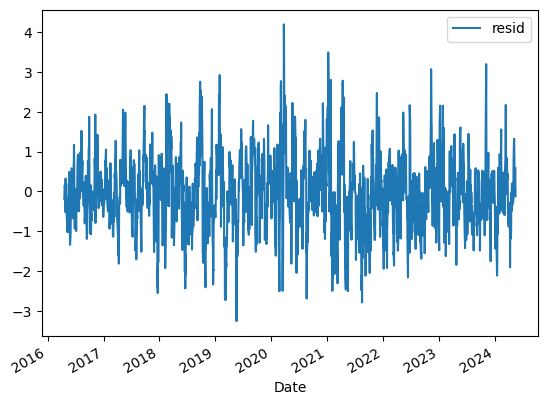

In [104]:
resid.plot()

In [132]:
resid.quantile(.05)

resid   -1.523702
Name: 0.05, dtype: float64

In [105]:
cross0 = ((resid * resid.shift(1) < 0) * 1 - 1).replace(-1, np.nan)
cross0_idx = cross0[cross0['resid'] == 0].index

short = ((resid > 1.5) * -1).replace(0, np.nan)
short.loc[cross0_idx] = 0
short = short.ffill()

long = ((resid < -1.5) * 1).replace(0, np.nan)
long.loc[cross0_idx] = 0
long = long.ffill()
# signal = ((resid > 1.5) * -1 + (resid < -1.5) * 1).replace(0, np.nan).ffill(limit=10).fillna(0)
signal = short + long
signal.columns = ['signal']

<Axes: xlabel='Date'>

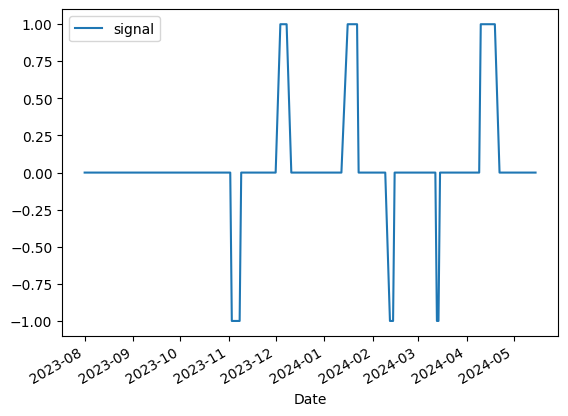

In [106]:
signal.iloc[-200:].plot()

In [107]:
notional = 1000000
leg2_shares = notional / s2

position = pd.DataFrame(index=Stock1.index, columns=[ticker1, ticker2])
position[ticker2] = leg2_shares
position[ticker1] = beta['beta'] * leg2_shares.reshape(-1)
position = position.mul(signal['signal'], axis=0)

In [108]:
position.tail()

,EPI,EWY
Date,,
2024-05-09,0.0,0.0
2024-05-10,0.0,0.0
2024-05-13,0.0,0.0
2024-05-14,0.0,0.0
2024-05-15,0.0,0.0


In [109]:
prices = pd.concat([Stock1['Adj Close'].to_frame(ticker1), Stock2['Adj Close'].to_frame(ticker2)], axis=1)
price_diff = prices.diff(1)

sharpe ratio: 0.29
maximum drawdown: -0.64
profitability: 0.53


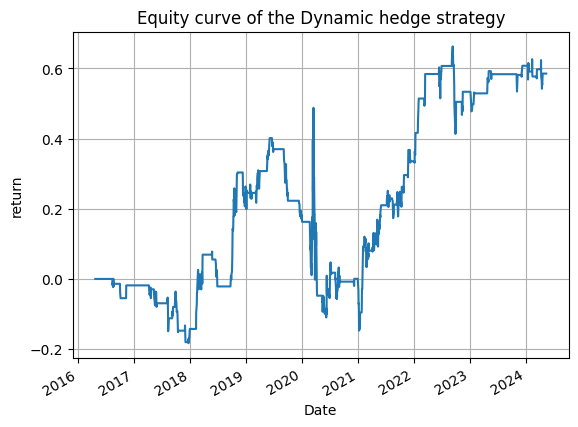

In [110]:
daily_return = (position.shift(1) * price_diff).sum(axis=1) / notional
daily_return.cumsum().plot(title='Equity curve of the Dynamic hedge strategy', grid = True)
plt.ylabel('return')
sharpe_ratio = daily_return.mean() * 252 / (daily_return.std() * np.sqrt(252))
mdd = (daily_return.cumsum() - daily_return.cumsum().cummax()).min()
winning_rate = (daily_return.replace(0, np.nan).dropna() > 0).mean()

print(f"sharpe ratio: {sharpe_ratio:.2f}")
print(f"maximum drawdown: {mdd:.2f}")
print(f"profitability: {winning_rate:.2f}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADF Statistic: -3.7228625007847893
p-value: 0.0038028264378963807
Critical Values: {'1%': -3.4339012073737605, '5%': -2.8631086593659174, '10%': -2.567605099413705}


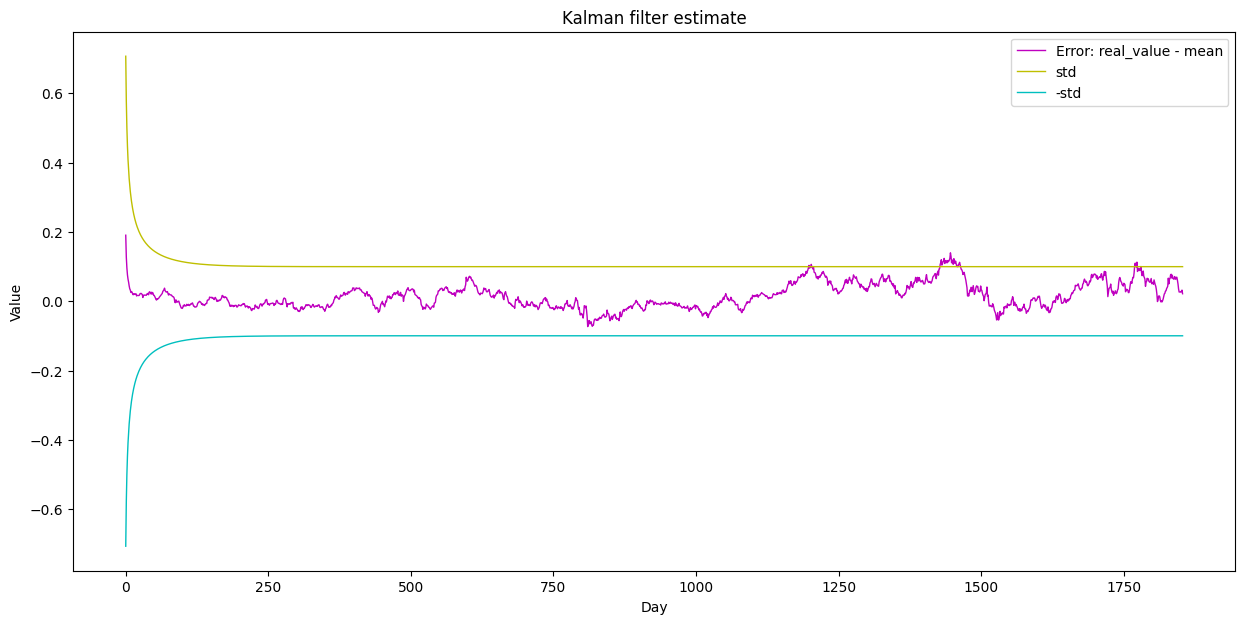

In [111]:
ticker1 = 'EPI'
ticker2 = 'EWY'

# Download data for two stocks
data1 = yf.download(ticker1, start="2017-01-01", end=datetime.today())
data2 = yf.download(ticker2, start="2017-01-01", end=datetime.today())

# Extract closing prices of the stocks
stock_1 = data1['Adj Close']
stock_2 = data2['Adj Close']

# Calculate the ratio of the closing prices for pairs trading
ratio = stock_1 / stock_2

data = pd.DataFrame()
data['Ratio'] = ratio

# Initialize Kalman Filter
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=.0001
)

# Apply Kalman Filter to the ratio data
mean, cov = kf.filter(ratio)
mean, std = mean.squeeze(), np.std(cov.squeeze())

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(ratio.values - mean, 'm', lw=1)  # Plotting error: real_value - mean
plt.plot(np.sqrt(cov.squeeze()), 'y', lw=1)  # Plotting standard deviation
plt.plot(-np.sqrt(cov.squeeze()), 'c', lw=1)  # Plotting negative standard deviation
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

# Calculate rolling mean and z_score
mean, cov = kf.filter(ratio)
data['mean'] = mean.squeeze()
data['cov'] = cov.squeeze()
data['std'] = np.sqrt(data['cov'])
data = data.dropna()
data['ma'] = data['Ratio'].rolling(5).mean()
data['z_score'] = (data['ma'] - data['mean']) / data['std']

# Display data
data.head()

# # Perform Augmented Dickey-Fuller (ADF) test for cointegration
adf_result = adfuller(ratio.values.reshape(-1) - mean.reshape(-1))
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

In [112]:
zscore = data[['z_score']]

In [113]:
cross0 = ((zscore * zscore.shift(1) < 0) * 1 - 1).replace(-1, np.nan)
cross0_idx = cross0[cross0['z_score'] == 0].index

short = ((zscore > 0.25) * -1).replace(0, np.nan)
short.loc[cross0_idx] = 0
short = short.ffill()

long = ((zscore < -0.25) * 1).replace(0, np.nan)
long.loc[cross0_idx] = 0
long = long.ffill()
# signal = ((resid > 1.5) * -1 + (resid < -1.5) * 1).replace(0, np.nan).ffill(limit=10).fillna(0)
signal = short + long
signal.columns = ['signal']

In [114]:
notional = 1000000
leg2_shares = notional / s2

position = pd.DataFrame(index=Stock1.index, columns=[ticker1, ticker2])
position[ticker2] = leg2_shares
position[ticker1] = -leg2_shares
position = position.mul(signal['signal'], axis=0)

sharpe ratio: -0.08
maximum drawdown: -0.49
profitability: 0.51


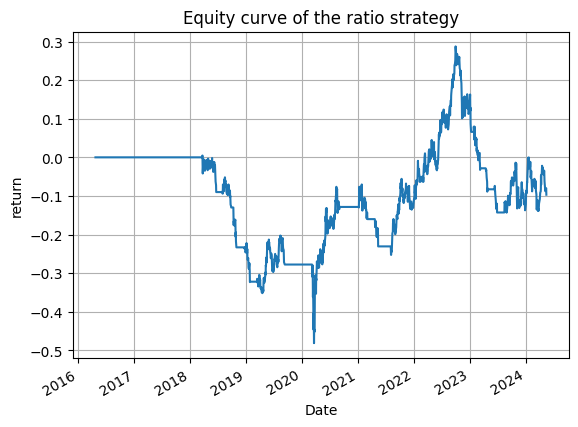

In [115]:
daily_return = (position.shift(1) * price_diff).sum(axis=1) / notional
daily_return.cumsum().plot(title='Equity curve of the ratio strategy', grid = True)
plt.ylabel('return')
sharpe_ratio = daily_return.mean() * 252 / (daily_return.std() * np.sqrt(252))
mdd = (daily_return.cumsum() - daily_return.cumsum().cummax()).min()
winning_rate = (daily_return.replace(0, np.nan).dropna() > 0).mean()

print(f"sharpe ratio: {sharpe_ratio:.2f}")
print(f"maximum drawdown: {mdd:.2f}")
print(f"profitability: {winning_rate:.2f}")

In [116]:
def fitKCA(t,z,q):
    '''
    Inputs:
    t: Iterable with time indices
    z: Iterable with measurements
    q: Scalar that multiplies the seed states covariance

    Output:
    x[0]: smoothed state means of position velocity and acceleration
    x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0]).days/t.shape[0]
    A=np.array([[1,h,.5*h**2],
    [0,1,h],
    [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)

    # Filtering
    state_means, state_covs = kf.filter(z)
    return state_means,state_covs

In [117]:
state_means,state_covs = fitKCA(resid.index, resid.values, 1)

In [118]:
state_covs.shape

(2031, 3, 3)

In [119]:
kca = pd.DataFrame(state_means, index=resid.index, columns=['p', 'v', 'a'])

<Axes: xlabel='Date'>

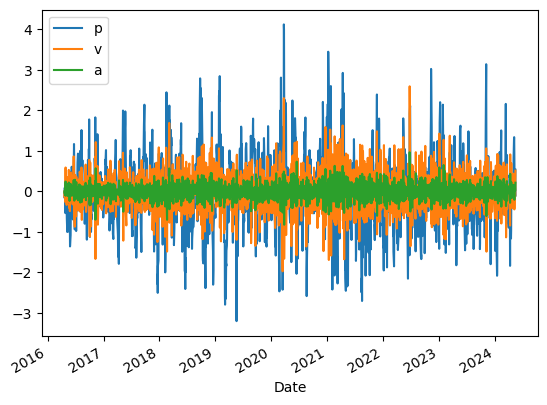

In [120]:
kca.plot()

<Axes: xlabel='Date'>

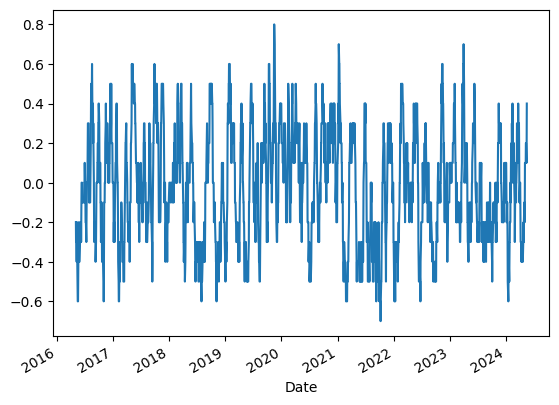

In [133]:
accgoesup = (((kca > 0.) * 1).sum(axis = 1) == 3) * 1
accgoesdown = (((kca < -0.) * 1).sum(axis = 1) == 3) * -1
momentum = (accgoesup + accgoesdown)
momentum.rolling(10).mean().plot()

In [124]:
signal = (momentum.rolling(10).mean() > 0.35) * -1 + (momentum.rolling(10).mean() < -0.35) * 1

In [125]:
notional = 1000000
leg2_shares = notional / s2

position = pd.DataFrame(index=Stock1.index, columns=[ticker1, ticker2])
position[ticker2] = leg2_shares
position[ticker1] = beta['beta'] * leg2_shares.reshape(-1)
position = position.mul(signal, axis=0)

sharpe ratio: 0.49
maximum drawdown: -0.31
profitability: 0.52


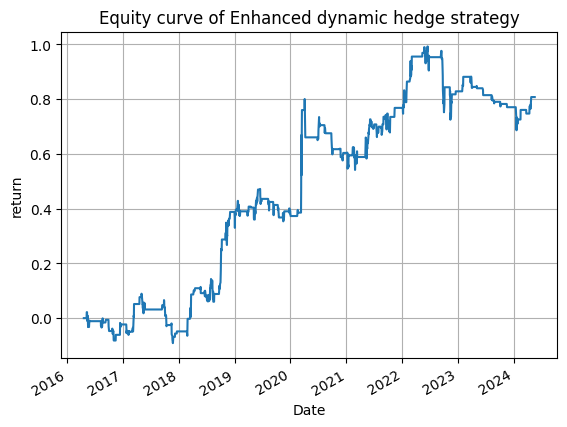

In [127]:
daily_return = (position.shift(1) * price_diff).sum(axis=1) / notional
daily_return.cumsum().plot(title='Equity curve of Enhanced dynamic hedge strategy', grid = True)
plt.ylabel('return')
sharpe_ratio = daily_return.mean() * 252 / (daily_return.std() * np.sqrt(252))
mdd = (daily_return.cumsum() - daily_return.cumsum().cummax()).min()
winning_rate = (daily_return.replace(0, np.nan).dropna() > 0).mean()

print(f"sharpe ratio: {sharpe_ratio:.2f}")
print(f"maximum drawdown: {mdd:.2f}")
print(f"profitability: {winning_rate:.2f}")